In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
some_data = np.random.normal(0, 1, 1536)
some_data[500] = 200
some_data[1000] = 1000
some_data_backup = some_data.copy()

In [ ]:
plt.plot(some_data_backup);

In [ ]:
'''
1: From the SIGPROC filterbank file '/data1/snr_tests_liam/20190214/dm10.0_nfrb50_153_sec_20190214-1515.fil':
                  Telescope = WSRT
                Source Name = RA22DEC52
            Obs Date String = 2018-04-12T02:37:53.0256
             MJD start time = 58220.10964149999927
                   RA J2000 = 22:00:00.0000
             RA J2000 (deg) = 330              
                  Dec J2000 = 52:00:00.0000
            Dec J2000 (deg) = 52               
                  Tracking? = True
              Azimuth (deg) = 55.29995
           Zenith Ang (deg) = 47.99912
            Number of polns = 2 (summed)
         Polarization order = 
           Sample time (us) = 40.96            
         Central freq (MHz) = 1400             
          Low channel (MHz) = 1250.09765625    
         High channel (MHz) = 1549.90234375    
        Channel width (MHz) = 0.1953125        
         Number of channels = 1536
      Total Bandwidth (MHz) = 300              
                       Beam = 1 of 1
            Beam FWHM (deg) = 1.000
         Spectra per subint = 2400
           Spectra per file = 975000
      Time per subint (sec) = 0.098304
        Time per file (sec) = 39.936
            bits per sample = 8
          bytes per spectra = 1536
        samples per spectra = 1536
           bytes per subint = 3686400
         samples per subint = 3686400
                zero offset = 0                
           Invert the band? = False
       bytes in file header = 455
''';

### Load & plot data

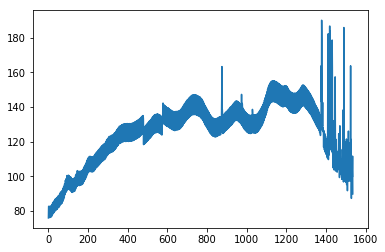

In [2]:
mean_spectrum = np.load('mean_spectrum_dm10.0_nfrb50_153_sec_20190214-1515.bk')[::-1]
plt.plot(mean_spectrum);

### Clean (new algo)

In [3]:
def compute_diff(some_data):
    diff_array = []
    for i in range(len(some_data)-1):
        diff_array.append(some_data[i]-some_data[i+1])
    diff_array = np.asarray(diff_array)
    
    return diff_array
    
def compute_clean(some_data, diff_array):
    for i in range(len(diff_array)):
        if np.abs(diff_array[i]-diff_array.mean()) > 3*diff_array.std():
            if i+2 > len(diff_array):
                some_data[i] = some_data[i-1]
            elif i-1 < 0:
                some_data[i] = some_data[i+2]
            else:
                some_data[i] = (some_data[i-1] + some_data[i+2])/2
            
    return some_data

In [4]:
mean_spec_diff = compute_diff(mean_spectrum)
mean_spec_clean = compute_clean(mean_spectrum, mean_spec_diff)

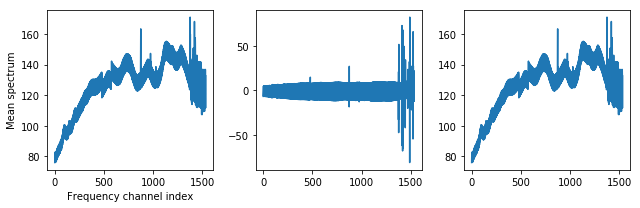

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].plot(mean_spectrum)
ax[1].plot(mean_spec_diff)
ax[2].plot(mean_spec_clean)
ax[0].set_ylabel('Mean spectrum')
ax[0].set_xlabel('Frequency channel index')
plt.tight_layout()
plt.savefig('rfi_clean_v2.pdf')

### Clean (current algo)

In [35]:
def compute_bins(some_data, n_per_bin=32):    
    b = 0
    nbins = int(np.ceil(some_data.shape[0] / n_per_bin))
    new_data = np.empty(nbins)
    
    for i in range(len(some_data)):
        if i!=0  and np.mod(i, n_per_bin)==0:
            b += 1
        
        new_data[b] += some_data[i]
        
    new_data /= n_per_bin
    return new_data

def compute_diff_w_bins(some_data, binned_data, n_per_bin=32):
    diff = np.empty(some_data.shape[0])
    b = 0
    nbins = int(np.ceil(some_data.shape[0] / n_per_bin))
    
    for i in range(len(some_data)):
        if i!=0  and np.mod(i, nbins)==0:
            b += 1

        diff[i] = some_data[i] - binned_data[b]
    return diff
            
def compute_clean_w_bins(some_data, binned_data, diff_data, n_per_bin=32):
    b = 0
    nbins = int(np.ceil(some_data.shape[0] / n_per_bin))
    
    for i in range(len(some_data)):
        if i!=0  and np.mod(i, nbins)==0:
            b += 1
            
        if np.abs(diff_data[i] - diff_data.mean()) > 3*diff_data.std():
            some_data[i] = binned_data[b]
            
    return some_data

In [36]:
mean_spectrum_bins = compute_bins(mean_spectrum)
mean_spectrum_bins_diff = compute_diff_w_bins(mean_spectrum, mean_spectrum_bins)
mean_spectrum_bins_clean = compute_clean_w_bins(mean_spectrum, mean_spectrum_bins, mean_spectrum_bins_diff)

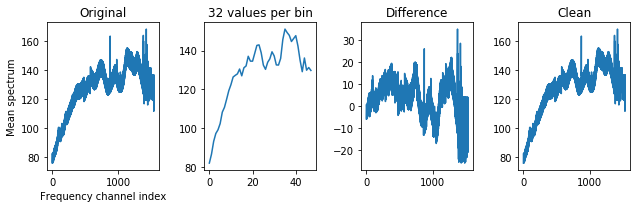

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(9, 3))

ax[0].plot(mean_spectrum)
ax[0].set_title('Original')
ax[1].plot(mean_spectrum_bins)
ax[1].set_title('32 values per bin')
ax[2].plot(mean_spectrum_bins_diff)
ax[2].set_title('Difference')
ax[3].plot(mean_spectrum_bins_clean)
ax[3].set_title('Clean')
ax[0].set_ylabel('Mean spectrum')
ax[0].set_xlabel('Frequency channel index')
plt.tight_layout()
plt.savefig('rfi_clean_v1.pdf')